# Import Libraries

In [51]:
import pandas as pd
import numpy as np
from sklearn.impute import KNNImputer
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tools.tools import add_constant
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Obtain Data

Read csv with player stats into pandas

In [17]:
stats_df = pd.read_csv('Data/player_stats.csv')
print('stats_df shape:', stats_df.shape)
stats_df.head()

stats_df shape: (530, 29)


,Player,Pos,Age,Tm,G,GS,MP,FG,FGA,FG%,...,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS
0,Álex Abrines,SG,25,OKC,31,2,588,56,157,0.357,...,0.923,5,43,48,20,17,6,14,53,165
1,Quincy Acy,PF,28,PHO,10,0,123,4,18,0.222,...,0.700,3,22,25,8,1,4,4,24,17
2,Jaylen Adams,PG,22,ATL,34,1,428,38,110,0.345,...,0.778,11,49,60,65,14,5,28,45,108
3,Steven Adams,C,25,OKC,80,80,2669,481,809,0.595,...,0.500,391,369,760,124,117,76,135,204,1108
4,Bam Adebayo,C,21,MIA,82,28,1913,280,486,0.576,...,0.735,165,432,597,184,71,65,121,203,729


Read csv with combine data into pandas

In [18]:
combine_df = pd.read_csv('Data/combine_measurements.csv')
print('combine_df shape:', combine_df.shape)
combine_df.head()

combine_df shape: (1273, 11)


,Year,Player,Pos,Body Fat %,Hand Length (Inches),Hand Width (Inches),Height W/O Shoes,Height W/ Shoes,Standing Reach,Weight (Lbs),Wingspan
0,2000-01,Primoz Brezec,C,-%,-,-,7' 0.75'',NaN,9' 2'',243.0,7' 2''
1,2000-01,Ndongo N'diaye,C,-%,-,-,6' 11.5'',NaN,9' 4.5'',208.0,7' 3.5''
2,2000-01,Karim Shabazz,C,-%,-,-,6' 11.5'',NaN,9' 3.5'',224.0,7' 3''
3,2000-01,Dan McClintock,C-PF,-%,-,-,6' 11'',NaN,8' 11'',250.0,7' 1.5''
4,2000-01,Ernest Brown,C,-%,-,-,6' 10'',NaN,9' 1.5'',222.5,7' 1.25''


Merge combine_df and stats_df together

In [19]:
df = pd.merge(stats_df, combine_df, on='Player')
print('df shape:', df.shape)
df.head()

df shape: (325, 39)


,Player,Pos_x,Age,Tm,G,GS,MP,FG,FGA,FG%,...,Year,Pos_y,Body Fat %,Hand Length (Inches),Hand Width (Inches),Height W/O Shoes,Height W/ Shoes,Standing Reach,Weight (Lbs),Wingspan
0,Quincy Acy,PF,28,PHO,10,0,123,4,18,0.222,...,2012-13,PF,7.10%,9.50,11.00,6' 6.5'',6' 7.75'',8' 10.5'',223.8,7' 2.75''
1,Steven Adams,C,25,OKC,80,80,2669,481,809,0.595,...,2013-14,C,6.65%,9.50,11.00,6' 10.75'',7' 0'',9' 1.5'',254.5,7' 4.5''
2,LaMarcus Aldridge,C,33,SAS,81,81,2687,684,1319,0.519,...,2006-07,PF-C,8.70%,-,-,6' 10'',6' 11.25'',9' 2'',234.0,7' 4.75''
3,Rawle Alkins,SG,21,CHI,10,1,120,13,39,0.333,...,2017-18,SG-SF,11.00%,8.75,10.00,6' 2.5'',6' 3.75'',8' 3'',222.6,6' 8.75''
4,Rawle Alkins,SG,21,CHI,10,1,120,13,39,0.333,...,2018-19,SG,8.90%,8.50,10.00,6' 2.75'',6' 4.25'',8' 3'',217.4,6' 8.75''


# Scrub Data

Use df.info() to determine what scrubbing needed

In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 325 entries, 0 to 324
Data columns (total 39 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Player                325 non-null    object 
 1   Pos_x                 325 non-null    object 
 2   Age                   325 non-null    int64  
 3   Tm                    325 non-null    object 
 4   G                     325 non-null    int64  
 5   GS                    325 non-null    int64  
 6   MP                    325 non-null    int64  
 7   FG                    325 non-null    int64  
 8   FGA                   325 non-null    int64  
 9   FG%                   322 non-null    float64
 10  3P                    325 non-null    int64  
 11  3PA                   325 non-null    int64  
 12  3P%                   305 non-null    float64
 13  2P                    325 non-null    int64  
 14  2PA                   325 non-null    int64  
 15  2P%                   3

Drop columns not useful for modeling

In [21]:
drop_columns = ['Player', 'Pos_x', 'Age', 'Tm', 'G', 'GS', 'MP', 'FG', 'FGA','FG%', '3P', '3PA', '2P', '2PA', '2P%',
                'eFG%', 'FT', 'FTA', 'FT%', 'ORB', 'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS', 'Year', 
                'Pos_y']
df.drop(columns=drop_columns, inplace=True)
print('df shape:', df.shape)
df.head()

df shape: (325, 9)


,3P%,Body Fat %,Hand Length (Inches),Hand Width (Inches),Height W/O Shoes,Height W/ Shoes,Standing Reach,Weight (Lbs),Wingspan
0,0.133,7.10%,9.50,11.00,6' 6.5'',6' 7.75'',8' 10.5'',223.8,7' 2.75''
1,0.000,6.65%,9.50,11.00,6' 10.75'',7' 0'',9' 1.5'',254.5,7' 4.5''
2,0.238,8.70%,-,-,6' 10'',6' 11.25'',9' 2'',234.0,7' 4.75''
3,0.250,11.00%,8.75,10.00,6' 2.5'',6' 3.75'',8' 3'',222.6,6' 8.75''
4,0.250,8.90%,8.50,10.00,6' 2.75'',6' 4.25'',8' 3'',217.4,6' 8.75''


Replace all '-' datapoints indicating a missing value in df with np.nan

In [22]:
df.replace({'-': np.nan, '-%': np.nan}, inplace=True)
df.head()

,3P%,Body Fat %,Hand Length (Inches),Hand Width (Inches),Height W/O Shoes,Height W/ Shoes,Standing Reach,Weight (Lbs),Wingspan
0,0.133,7.10%,9.50,11.00,6' 6.5'',6' 7.75'',8' 10.5'',223.8,7' 2.75''
1,0.000,6.65%,9.50,11.00,6' 10.75'',7' 0'',9' 1.5'',254.5,7' 4.5''
2,0.238,8.70%,NaN,NaN,6' 10'',6' 11.25'',9' 2'',234.0,7' 4.75''
3,0.250,11.00%,8.75,10.00,6' 2.5'',6' 3.75'',8' 3'',222.6,6' 8.75''
4,0.250,8.90%,8.50,10.00,6' 2.75'',6' 4.25'',8' 3'',217.4,6' 8.75''


Update 'Body Fat %' column data type from string to float

In [23]:
def scrub_bf(val):
    if type(val) == float:
        return val
    else:
        return float(val.replace('%', ''))/100
    
df['Body Fat %'] = df['Body Fat %'].apply(scrub_bf)
df.head()

,3P%,Body Fat %,Hand Length (Inches),Hand Width (Inches),Height W/O Shoes,Height W/ Shoes,Standing Reach,Weight (Lbs),Wingspan
0,0.133,0.0710,9.50,11.00,6' 6.5'',6' 7.75'',8' 10.5'',223.8,7' 2.75''
1,0.000,0.0665,9.50,11.00,6' 10.75'',7' 0'',9' 1.5'',254.5,7' 4.5''
2,0.238,0.0870,NaN,NaN,6' 10'',6' 11.25'',9' 2'',234.0,7' 4.75''
3,0.250,0.1100,8.75,10.00,6' 2.5'',6' 3.75'',8' 3'',222.6,6' 8.75''
4,0.250,0.0890,8.50,10.00,6' 2.75'',6' 4.25'',8' 3'',217.4,6' 8.75''


Update 'Hand Length (Inches)', 'Hand Width (Inches)' and 'Weight (Lbs)' column data types to float

In [24]:
dtype_dict = {'Hand Length (Inches)':float, 'Hand Width (Inches)': float, 'Weight (Lbs)': float}
df = df.astype(dtype_dict)
df.head()

,3P%,Body Fat %,Hand Length (Inches),Hand Width (Inches),Height W/O Shoes,Height W/ Shoes,Standing Reach,Weight (Lbs),Wingspan
0,0.133,0.0710,9.50,11.0,6' 6.5'',6' 7.75'',8' 10.5'',223.8,7' 2.75''
1,0.000,0.0665,9.50,11.0,6' 10.75'',7' 0'',9' 1.5'',254.5,7' 4.5''
2,0.238,0.0870,NaN,NaN,6' 10'',6' 11.25'',9' 2'',234.0,7' 4.75''
3,0.250,0.1100,8.75,10.0,6' 2.5'',6' 3.75'',8' 3'',222.6,6' 8.75''
4,0.250,0.0890,8.50,10.0,6' 2.75'',6' 4.25'',8' 3'',217.4,6' 8.75''


Update remaining object type columns measured in feet to float type measured in inches

In [25]:
def feet_to_inches(val):
    if type(val) == float:
        return val
    else:
        val = val.replace("'", "")
        val = val.replace('"', '')
        return 12*float(val.split(' ')[0]) + float(val.split(' ')[1])

feet_cols = ['Height W/O Shoes', 'Height W/ Shoes', 'Standing Reach', 'Wingspan']
for col in feet_cols:
    df[col] = df[col].apply(feet_to_inches)
df.head()

,3P%,Body Fat %,Hand Length (Inches),Hand Width (Inches),Height W/O Shoes,Height W/ Shoes,Standing Reach,Weight (Lbs),Wingspan
0,0.133,0.0710,9.50,11.0,78.50,79.75,106.5,223.8,86.75
1,0.000,0.0665,9.50,11.0,82.75,84.00,109.5,254.5,88.50
2,0.238,0.0870,NaN,NaN,82.00,83.25,110.0,234.0,88.75
3,0.250,0.1100,8.75,10.0,74.50,75.75,99.0,222.6,80.75
4,0.250,0.0890,8.50,10.0,74.75,76.25,99.0,217.4,80.75


Drop all rows missing 3P% dependent variable

In [26]:
df.dropna(subset=['3P%'], inplace=True)
df.reset_index(drop=True, inplace=True)
df.head()

,3P%,Body Fat %,Hand Length (Inches),Hand Width (Inches),Height W/O Shoes,Height W/ Shoes,Standing Reach,Weight (Lbs),Wingspan
0,0.133,0.0710,9.50,11.0,78.50,79.75,106.5,223.8,86.75
1,0.000,0.0665,9.50,11.0,82.75,84.00,109.5,254.5,88.50
2,0.238,0.0870,NaN,NaN,82.00,83.25,110.0,234.0,88.75
3,0.250,0.1100,8.75,10.0,74.50,75.75,99.0,222.6,80.75
4,0.250,0.0890,8.50,10.0,74.75,76.25,99.0,217.4,80.75


Drop 'Height W/ Shoes' column, which is essentially the same as 'Height W/O Shoes' column but missing more values

In [27]:
df.drop(columns=['Height W/ Shoes'], inplace=True)
df.head()

,3P%,Body Fat %,Hand Length (Inches),Hand Width (Inches),Height W/O Shoes,Standing Reach,Weight (Lbs),Wingspan
0,0.133,0.0710,9.50,11.0,78.50,106.5,223.8,86.75
1,0.000,0.0665,9.50,11.0,82.75,109.5,254.5,88.50
2,0.238,0.0870,NaN,NaN,82.00,110.0,234.0,88.75
3,0.250,0.1100,8.75,10.0,74.50,99.0,222.6,80.75
4,0.250,0.0890,8.50,10.0,74.75,99.0,217.4,80.75


Impute missing values with knn imputer

In [28]:
imputer_df = df.drop(columns=['3P%'])
imputer_ss = StandardScaler()
imputer_df = pd.DataFrame(imputer_ss.fit_transform(imputer_df), columns=imputer_df.columns)
imputer = KNNImputer()
imputer_df = pd.DataFrame(imputer.fit_transform(imputer_df), columns=imputer_df.columns)
imputer_df = pd.DataFrame(imputer_ss.inverse_transform(imputer_df), columns=imputer_df.columns)
df = pd.merge(df[['3P%']], imputer_df, left_index=True, right_index=True)
df.head()

,3P%,Body Fat %,Hand Length (Inches),Hand Width (Inches),Height W/O Shoes,Standing Reach,Weight (Lbs),Wingspan
0,0.133,0.0710,9.50,11.0,78.50,106.5,223.8,86.75
1,0.000,0.0665,9.50,11.0,82.75,109.5,254.5,88.50
2,0.238,0.0870,9.10,9.8,82.00,110.0,234.0,88.75
3,0.250,0.1100,8.75,10.0,74.50,99.0,222.6,80.75
4,0.250,0.0890,8.50,10.0,74.75,99.0,217.4,80.75


Confirm data is now scrubbed with df.info()

In [29]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 305 entries, 0 to 304
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   3P%                   305 non-null    float64
 1   Body Fat %            305 non-null    float64
 2   Hand Length (Inches)  305 non-null    float64
 3   Hand Width (Inches)   305 non-null    float64
 4   Height W/O Shoes      305 non-null    float64
 5   Standing Reach        305 non-null    float64
 6   Weight (Lbs)          305 non-null    float64
 7   Wingspan              305 non-null    float64
dtypes: float64(8)
memory usage: 19.2 KB


# Explore Data

Find 10 greatest outlier datapoints with isolation forest

In [30]:
isolation_df = df.drop(columns=['3P%'])
isf_ss = StandardScaler()
isolation_df = pd.DataFrame(isf_ss.fit_transform(isolation_df), columns=isolation_df.columns)
isolation_forest = IsolationForest(contamination=.03)
isolation_df['Outlier'] = isolation_forest.fit_predict(isolation_df)
isolation_df[isolation_df['Outlier']==-1]

,Body Fat %,Hand Length (Inches),Hand Width (Inches),Height W/O Shoes,Standing Reach,Weight (Lbs),Wingspan,Outlier
14,0.549202,-1.709801,-1.369582,-2.419185,-1.890774,-1.610852,-1.977524,-1
50,-1.303625,1.300492,-1.449544,-1.690903,-1.781399,-0.636597,-1.764822,-1
63,4.442484,1.300492,0.949305,1.303147,2.156108,3.134205,2.063818,-1
89,-0.454608,-0.204654,0.309612,-0.800780,-0.687647,-8.375417,-0.275906,-1
96,1.018273,-1.835230,-2.648968,-2.176425,-1.781399,-1.070476,-1.410318,-1
177,-0.717287,2.554781,2.948346,0.170263,0.624855,0.594041,1.283910,-1
271,-0.107496,-1.208085,-0.649927,-2.823787,-2.547025,-1.038921,-2.473829,-1
279,0.173946,2.554781,3.747962,0.817625,1.062356,1.371079,1.638413,-1
291,-0.670380,-1.208085,1.349113,1.626828,2.156108,0.562486,2.418321,-1
298,3.645065,1.300492,2.148729,1.222226,1.827982,0.144385,1.354810,-1


Replace 0 values for all features with np.nan and impute these missing values in order to fix the improperly entered datapoint 89, which has a Weight of 0

In [31]:
print(df.iloc[89])
zero_imputer_df = df.drop(columns=['3P%'])
zero_imputer_df.replace({0: np.nan}, inplace=True)
zero_imputer_ss = StandardScaler()
zero_imputer_df = pd.DataFrame(zero_imputer_ss.fit_transform(zero_imputer_df), columns=zero_imputer_df.columns)
zero_imputer = KNNImputer()
zero_imputer_df = pd.DataFrame(zero_imputer.fit_transform(zero_imputer_df), columns=zero_imputer_df.columns)
zero_imputer_df = pd.DataFrame(zero_imputer_ss.inverse_transform(zero_imputer_df), columns=zero_imputer_df.columns)
df = pd.merge(df[['3P%']], zero_imputer_df, left_index=True, right_index=True)
df.head()

3P%                       0.3540
Body Fat %                0.0596
Hand Length (Inches)      8.6500
Hand Width (Inches)       9.6000
Height W/O Shoes         75.0000
Standing Reach          100.0000
Weight (Lbs)              0.0000
Wingspan                 81.5000
Name: 89, dtype: float64


,3P%,Body Fat %,Hand Length (Inches),Hand Width (Inches),Height W/O Shoes,Standing Reach,Weight (Lbs),Wingspan
0,0.133,0.0710,9.50,11.0,78.50,106.5,223.8,86.75
1,0.000,0.0665,9.50,11.0,82.75,109.5,254.5,88.50
2,0.238,0.0870,9.10,9.8,82.00,110.0,234.0,88.75
3,0.250,0.1100,8.75,10.0,74.50,99.0,222.6,80.75
4,0.250,0.0890,8.50,10.0,74.75,99.0,217.4,80.75


View descriptive statistics for each variable with df.describe()

In [34]:
df.describe()

,3P%,Body Fat %,Hand Length (Inches),Hand Width (Inches),Height W/O Shoes,Standing Reach,Weight (Lbs),Wingspan
count,305.000000,305.000000,305.000000,305.000000,305.000000,305.000000,305.000000,305.000000
mean,0.313308,0.069292,8.731582,9.406400,77.473979,103.143523,213.004367,82.472862
std,0.123649,0.021354,0.399287,0.626328,3.094538,4.578933,22.280341,3.531852
min,0.000000,0.030000,7.500000,7.750000,68.750000,91.500000,166.200000,73.750000
25%,0.290000,0.054000,8.500000,9.000000,75.500000,100.000000,196.200000,80.000000
50%,0.336000,0.065000,8.750000,9.400000,77.750000,103.000000,212.600000,82.472862
75%,0.371000,0.080000,9.000000,9.750000,79.750000,106.500000,228.000000,84.750000
max,1.000000,0.164000,9.750000,11.750000,83.750000,114.500000,291.800000,91.000000


Plot the distribution of each variable

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your c

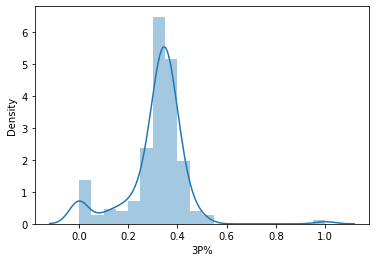

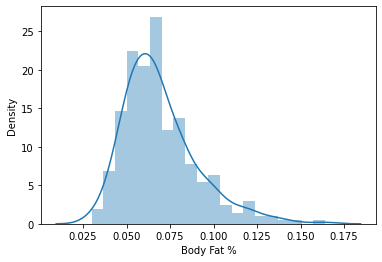

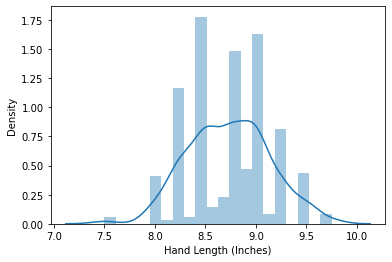

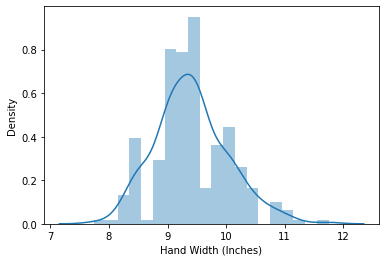

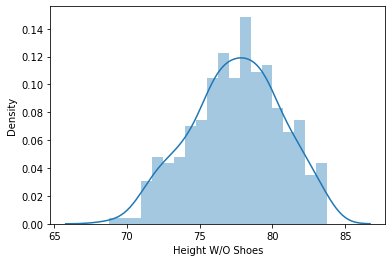

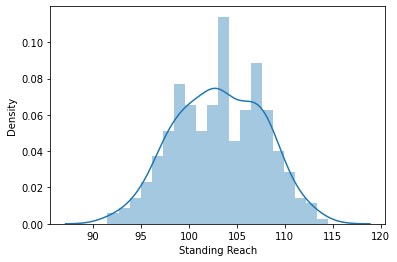

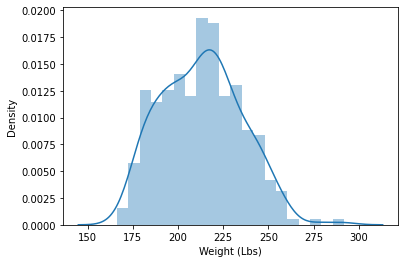

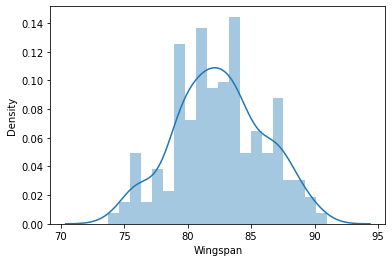

In [38]:
for col in df.columns:
    fig, ax = plt.subplots()
    sns.distplot(df[col], kde=True, bins=20)

Plot the relationship between each independent variable and the dependent variable

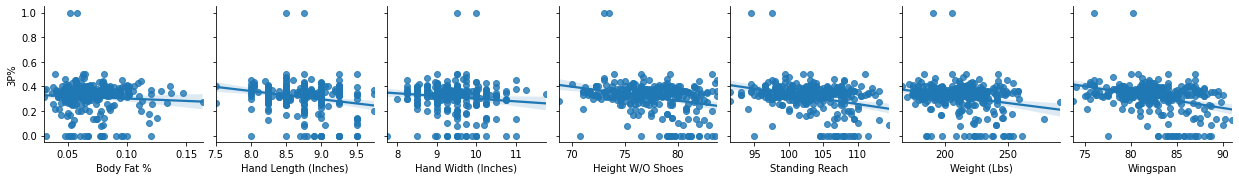

In [49]:
y_var = '3P%'
x_vars = list(df.columns)
x_vars.remove(x_var)

sns.pairplot(df, x_vars = x_vars, y_vars=y_var, kind='reg')

Calculate vif to determine features with highest correlations

In [65]:
vif_df = add_constant(df.drop(columns='3P%'))
vif_output = []
for num in range(0, len(vif_df.columns)):
    vif_output.append([vif_df.columns[num], variance_inflation_factor(vif_df.values, num)])
pd.DataFrame(vif_output, columns=['Column', 'VIF'])

,Column,VIF
0,const,1073.735789
1,Body Fat %,1.466607
2,Hand Length (Inches),2.372516
3,Hand Width (Inches),1.408032
4,Height W/O Shoes,6.860011
5,Standing Reach,10.456753
6,Weight (Lbs),3.132649
7,Wingspan,6.217376


Drop 'Standing Reach' with highest vif correlation and recalculate vif to confirm no need to drop more features with vif above 5

In [67]:
df.drop(columns='Standing Reach', inplace=True)
vif_df = add_constant(df.drop(columns='3P%'))
vif_output = []
for num in range(0, len(vif_df.columns)):
    vif_output.append([vif_df.columns[num], variance_inflation_factor(vif_df.values, num)])
pd.DataFrame(vif_output, columns=['Column', 'VIF'])

,Column,VIF
0,const,1024.671617
1,Body Fat %,1.426308
2,Hand Length (Inches),2.371674
3,Hand Width (Inches),1.405276
4,Height W/O Shoes,3.320086
5,Weight (Lbs),3.081033
6,Wingspan,3.883507
